## SETUP

In [ ]:
!pip install gym[classic_control]
!pip install dezero

## ch08/gym_play.py

In [ ]:
import numpy as np  # 数のかたまりをあつかう道具
import gym  # ゲームの世界をつくる道具（AIの勉強用）

env = gym.make('CartPole-v0')  # カートポールというゲームをよび出す
state = env.reset()  # ゲームをスタート（はじめの状態をもらう）
done = False  # ゲームが終わったかどうか（まだだからFalse）

while not done:  # ゲームが終わるまでくり返すよ
    env.render()  # ゲーム画面を表示したいときはこの行のコメントを外す（画面で見る用）
    action = np.random.choice([0, 1])  # ランダムに0（左）か1（右）を選ぶ
    next_state, reward, done, info = env.step(action)  # 行動して次の状態と報酬をもらう
    print('action:', action)  # 今の行動を表示する
# env.close()  # ゲームを終了（画面を閉じるときに使う）


action: 0
action: 0
action: 0
action: 1
action: 1
action: 0
action: 0
action: 0
action: 0
action: 0
action: 0
action: 1
action: 0


## ch08/replay_buffer.py

In [ ]:
from collections import deque  # キュー（並べて記録する）の道具
import random  # ランダムに選ぶための道具
import numpy as np  # 数のかたまりを使う道具
import gym  # ゲームの環境を作る道具

# 🎒 過去の経験をためるリプレイバッファ
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.buffer = deque(maxlen=buffer_size)  # 古いものから消える箱
        self.batch_size = batch_size  # まとめて何個取り出すか

    def add(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)  # 1回分の記録
        self.buffer.append(data)  # お弁当箱に追加

    def __len__(self):
        return len(self.buffer)  # 中に何個入ってるか

    def get_batch(self):
        data = random.sample(self.buffer, self.batch_size)  # ランダムに取り出す

        state = np.stack([x[0] for x in data])  # 状態だけまとめる（行列に）
        action = np.array([x[1] for x in data])  # 行動だけまとめる
        reward = np.array([x[2] for x in data])  # 報酬だけまとめる
        next_state = np.stack([x[3] for x in data])  # 次の状態まとめる
        done = np.array([x[4] for x in data]).astype(np.int32)  # 終わったかまとめる（True→1）
        return state, action, reward, next_state, done  # 5つのデータを返す

# 🎮 ゲーム（カートポール）スタート
env = gym.make('CartPole-v0')  # 環境をつくる
replay_buffer = ReplayBuffer(buffer_size=10000, batch_size=32)  # 経験をためる準備

for episode in range(10):  # 10回ゲームする
    state = env.reset()  # ゲームをはじめる
    done = False  # 終わったかどうか

    while not done:  # ゲームが終わるまでくり返す
        action = 0  # ここではずっと「左に動く」
        next_state, reward, done, info = env.step(action)  # 行動して次の状態へ
        replay_buffer.add(state, action, reward, next_state, done)  # 経験を追加！
        state = next_state  # 状態を更新

# 🍱 たまった経験から32個ランダムに取り出す！
state, action, reward, next_state, done = replay_buffer.get_batch()

# 📏 データの形を確認する（ちゃんと32個ずつあるか）
print(state.shape)      # (32, 4) 状態ベクトルは4つの数字がある
print(action.shape)     # (32,) 行動は0か1
print(reward.shape)     # (32,) 報酬（たいてい1）
print(next_state.shape) # (32, 4) 次の状態
print(done.shape)       # (32,) 終わったか（0か1）


(32, 4)
(32,)
(32,)
(32, 4)
(32,)


## ch08/dqn.py

episode :0, total reward : 14.0
episode :10, total reward : 98.0
episode :20, total reward : 38.0
episode :30, total reward : 20.0
episode :40, total reward : 12.0
episode :50, total reward : 10.0
episode :60, total reward : 23.0
episode :70, total reward : 17.0
episode :80, total reward : 9.0
episode :90, total reward : 124.0
episode :100, total reward : 122.0
episode :110, total reward : 186.0
episode :120, total reward : 156.0
episode :130, total reward : 198.0
episode :140, total reward : 146.0
episode :150, total reward : 200.0
episode :160, total reward : 200.0
episode :170, total reward : 193.0
episode :180, total reward : 200.0
episode :190, total reward : 142.0
episode :200, total reward : 200.0
episode :210, total reward : 200.0
episode :220, total reward : 179.0
episode :230, total reward : 149.0
episode :240, total reward : 200.0
episode :250, total reward : 200.0
episode :260, total reward : 200.0
episode :270, total reward : 200.0
episode :280, total reward : 200.0
episod

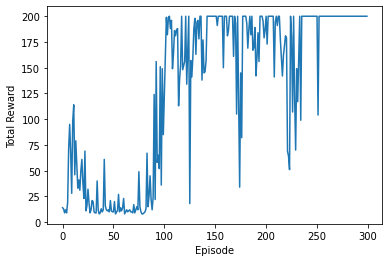

Total Reward: 200.0


In [ ]:
import copy  # コピーする道具
from collections import deque  # キュー（順番にデータを出し入れ）を使う
import random  # ランダムに選ぶ道具
import matplotlib.pyplot as plt  # グラフを描く道具
import numpy as np  # 数のまとまり（配列）を使う道具
import gym  # ゲームの環境を作る道具
from dezero import Model  # ニューラルネットのもと
from dezero import optimizers  # 学習の方法を決める
import dezero.functions as F  # 数学の関数を使う
import dezero.layers as L  # ニューラルネットの部品（レイヤー）

# 🎒 過去の経験をためるバッファ
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.buffer = deque(maxlen=buffer_size)  # 最大buffer_size個ためられる
        self.batch_size = batch_size  # 一度に取り出す数

    def add(self, state, action, reward, next_state, done):
        data = (state, action, reward, next_state, done)  # 体験をセットにする
        self.buffer.append(data)  # バッファに追加する

    def __len__(self):
        return len(self.buffer)  # 中にいくつ入ってるか返す

    def get_batch(self):
        data = random.sample(self.buffer, self.batch_size)  # ランダムにbatchサイズ取り出す
        state = np.stack([x[0] for x in data])  # 状態をまとめる
        action = np.array([x[1] for x in data])  # 行動をまとめる
        reward = np.array([x[2] for x in data])  # 報酬をまとめる
        next_state = np.stack([x[3] for x in data])  # 次の状態をまとめる
        done = np.array([x[4] for x in data]).astype(np.int32)  # 終了フラグをまとめる
        return state, action, reward, next_state, done  # 5つの情報を返す

# 🧠 Q値を出すためのニューラルネット（3層）
class QNet(Model):
    def __init__(self, action_size):
        super().__init__()  # 基本の設定
        self.l1 = L.Linear(128)  # 1つ目の隠れ層
        self.l2 = L.Linear(128)  # 2つ目の隠れ層
        self.l3 = L.Linear(action_size)  # 最後の出力層（行動の数）

    def forward(self, x):
        x = F.relu(self.l1(x))  # 最初の層を通してReLUで変形
        x = F.relu(self.l2(x))  # 次の層もReLUで変形
        x = self.l3(x)  # 最後の層でQ値を出す
        return x  # Q値を返す

# 🎮 DQNエージェント（学習するAI）
class DQNAgent:
    def __init__(self):
        self.gamma = 0.98  # 将来の報酬の重み
        self.lr = 0.0005  # 学習率（どれくらい重みを変えるか）
        self.epsilon = 0.1  # ランダムに動く確率
        self.buffer_size = 10000  # バッファの大きさ
        self.batch_size = 32  # 一度に学習する数
        self.action_size = 2  # 行動は2つ（左か右）

        self.replay_buffer = ReplayBuffer(self.buffer_size, self.batch_size)  # バッファ作成
        self.qnet = QNet(self.action_size)  # メインのネットワーク
        self.qnet_target = QNet(self.action_size)  # ターゲットネットワーク
        self.optimizer = optimizers.Adam(self.lr)  # 学習方法をAdamにする
        self.optimizer.setup(self.qnet)  # 学習するのはメインネットワーク

    def get_action(self, state):
        if np.random.rand() < self.epsilon:  # εの確率でランダムな行動
            return np.random.choice(self.action_size)
        else:
            state = state[np.newaxis, :]  # 1次元→2次元に変形
            qs = self.qnet(state)  # Q値を出す
            return qs.data.argmax()  # 一番良いQ値の行動を選ぶ

    def update(self, state, action, reward, next_state, done):
        self.replay_buffer.add(state, action, reward, next_state, done)  # バッファに追加
        if len(self.replay_buffer) < self.batch_size:  # バッチサイズに足りないときは学習しない
            return

        # バッチを取り出す
        state, action, reward, next_state, done = self.replay_buffer.get_batch()
        qs = self.qnet(state)  # QネットでQ値を計算
        q = qs[np.arange(self.batch_size), action]  # 実際に取った行動のQ値を取り出す

        next_qs = self.qnet_target(next_state)  # 次の状態をターゲットネットで予測
        next_q = next_qs.max(axis=1)  # 一番良い行動のQ値を選ぶ
        next_q.unchain()  # 計算グラフを切る（効率化）

        target = reward + (1 - done) * self.gamma * next_q  # 正解のQ値を作る
        loss = F.mean_squared_error(q, target)  # 今のQと正解Qのズレ

        self.qnet.cleargrads()  # 勾配をリセット
        loss.backward()  # 勾配を計算
        self.optimizer.update()  # パラメータを更新！

    def sync_qnet(self):
        self.qnet_target = copy.deepcopy(self.qnet)  # メインネットをコピーしてターゲットにする

# 🎓 ゲームを実行して学習させる
episodes = 300  # 300回学習
sync_interval = 20  # 20回ごとにターゲットネットを更新
env = gym.make('CartPole-v0')  # ゲーム環境を作る
agent = DQNAgent()  # エージェントを作る
reward_history = []  # 報酬の記録

for episode in range(episodes):
    state = env.reset()  # ゲームをリセット
    done = False
    total_reward = 0  # 合計報酬を初期化

    while not done:  # ゲームが終わるまで
        action = agent.get_action(state)  # 行動を決める
        next_state, reward, done, info = env.step(action)  # 実際に行動する
        agent.update(state, action, reward, next_state, done)  # 学習！
        state = next_state  # 状態を更新
        total_reward += reward  # 報酬を合計

    if episode % sync_interval == 0:  # 一定回数ごとに
        agent.sync_qnet()  # ターゲットネットを更新！

    reward_history.append(total_reward)  # 報酬を記録
    if episode % 10 == 0:  # 10回ごとに表示
        print("episode :{}, total reward : {}".format(episode, total_reward))

# 📊 結果のグラフを表示！
plt.xlabel('Episode')  # 横のラベル
plt.ylabel('Total Reward')  # 縦のラベル
plt.plot(range(len(reward_history)), reward_history)  # 線グラフ
plt.show()  # グラフを表示

# 🎮 最後にゲームをプレイしてみる
agent.epsilon = 0  # もうランダムには動かさない
state = env.reset()  # ゲームをリセット
done = False
total_reward = 0

while not done:
    action = agent.get_action(state)  # 学習した行動を使う
    next_state, reward, done, info = env.step(action)  # ゲームを進める
    state = next_state  # 状態を更新
    total_reward += reward  # 報酬を足す
    # env.render()  # 画面で見たいときはコメントを外す

print('Total Reward:', total_reward)  # 最終スコアを表示！
